In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from tsfresh import feature_extraction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import NPYBoschCNCDataLoader, SimpleTSFreshBoschCNCDataloader
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples, extract_tsfresh_features

In [3]:
baseline_loader = SimpleTSFreshBoschCNCDataloader(
    metadata_path="/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/metadata_ws4096.pkl"
)
baseline_loader.load_data("/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/all_top_30_features.pkl", 
"/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/sample_data_y_raw_ws4096.npy")

In [4]:
baseline_loader.generate_datasets_by_size(train_size=.5,val_size=.1,test_size=.4, processes=["OP07"])

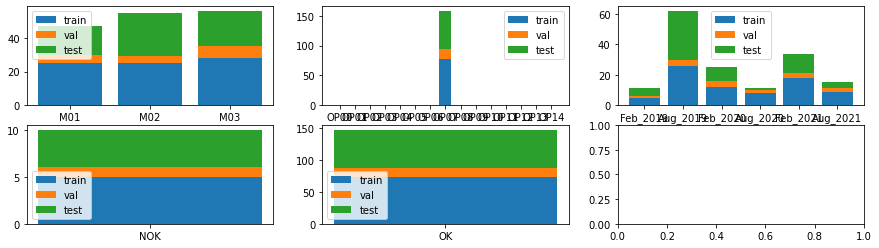

In [5]:
baseline_loader.plot_stats()

In [6]:
X_train = baseline_loader.sample_data_X.iloc[baseline_loader.train_sample_ids].to_numpy()
y_train = baseline_loader.sample_data_y[baseline_loader.train_sample_ids]

X_val = baseline_loader.sample_data_X.iloc[baseline_loader.val_sample_ids].to_numpy()
y_val = baseline_loader.sample_data_y[baseline_loader.val_sample_ids]

X_test = baseline_loader.sample_data_X.iloc[baseline_loader.test_sample_ids].to_numpy()
y_test = baseline_loader.sample_data_y[baseline_loader.test_sample_ids]

In [7]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

print("Training Set")
print(classification_report(y_train, y_pred_train, target_names=["OK", "NOK"]))
print("Validation Set")
print(classification_report(y_val, y_pred_val, target_names=["OK", "NOK"]))
print("Test Set")
print(classification_report(y_test, y_pred_test, target_names=["OK", "NOK"]))

Training Set
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       868
         NOK       1.00      1.00      1.00        44

    accuracy                           1.00       912
   macro avg       1.00      1.00      1.00       912
weighted avg       1.00      1.00      1.00       912

Validation Set
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       178
         NOK       1.00      1.00      1.00         9

    accuracy                           1.00       187
   macro avg       1.00      1.00      1.00       187
weighted avg       1.00      1.00      1.00       187

Test Set
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       711
         NOK       1.00      0.97      0.99        34

    accuracy                           1.00       745
   macro avg       1.00      0.99      0.99       745
weighted avg       1.00      1.00    

In [10]:
augmented_features_basepath = "/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/raw_data/augmented"
for axis in ["yaw", "pitch", "roll"]:
    for angle in np.arange(5.0, 25.0, 5.0):
        augmented_features_filename = f"tsfresh_top30_{axis}_shift_{angle}_deg.pkl"
        augmented_features_filepath = os.path.join(augmented_features_basepath, augmented_features_filename)
        
        augmented_loader = SimpleTSFreshBoschCNCDataloader(
            metadata_path="/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/metadata_ws4096.pkl"
        )
        augmented_loader.load_data(augmented_features_filepath, 
        "/home/tbiegel/nico_files/bosch_cnc_machining/features_and_data/sample_data_y_raw_ws4096.npy")

        print(f"Test set results for {angle} degrees shift in {axis}:")
        X_test = augmented_loader.sample_data_X.iloc[baseline_loader.test_sample_ids][baseline_loader.sample_data_X.columns].to_numpy()
        y_test = augmented_loader.sample_data_y[baseline_loader.test_sample_ids]
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test, target_names=["OK", "NOK"]))

Test set results for 5.0 degrees shift in yaw:
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       711
         NOK       1.00      0.94      0.97        34

    accuracy                           1.00       745
   macro avg       1.00      0.97      0.98       745
weighted avg       1.00      1.00      1.00       745

Test set results for 10.0 degrees shift in yaw:
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00       711
         NOK       1.00      0.91      0.95        34

    accuracy                           1.00       745
   macro avg       1.00      0.96      0.98       745
weighted avg       1.00      1.00      1.00       745

Test set results for 15.0 degrees shift in yaw:
              precision    recall  f1-score   support

          OK       0.99      1.00      1.00       711
         NOK       1.00      0.88      0.94        34

    accuracy                           